In [1]:
from collections import Counter
from language_api import detect_language
import pandas as pd, numpy as np, re, nltk

pd.options.display.max_colwidth = 150

df = pd.read_csv('datasets/edu/uoft_sudent_organizations.tsv', sep='\t', dtype=object)
show_cols = ['org_name', 'organization_type','description', 'areas_of_interest']
print(df.shape)
df.head(3)[show_cols]

(1401, 43)


,org_name,organization_type,description,areas_of_interest
0,A.Taj Aerospace medicine (A.Taj),Recognized Student Group,In my opinion human race is really behind in research related to our health in space as we are mainly focusing on human health on earth.\nOur asso...,"['Academic', 'Global Interests', 'Media']"
1,Academia Musica Historica (AMH),Recognized Student Group,The purpose of ‘Academia Musica Historica’ is aimed at bringing together students with a common interest in historical music here at the Universit...,"['Academic', 'Arts', 'Social']"
2,Academic Alliance at the University of Toronto,Recognized Student Group,Academic Alliance at the University of Toronto aims to provide immediate front-line peer support to students who are struggling academically at th...,"['Academic', 'Community Service', 'Social Justice/Advocacy']"


In [2]:
non_ascii_chars = '[^\x00-\x7F]'
mask = df.description.str.contains(non_ascii_chars, na=False)
(df[mask].description.str.extractall(f'({non_ascii_chars})').reset_index(level=0, drop=True)[0].unique())

array(['‘', '’', '–', '“', '”', 'ó', '•', '：', '\xa0', '—', 'é', 'á', 'í',
       'É', '歌', '之', '王', '）', 'ū', '竹', '内', '流', '備', '中', '伝', '‐',
       'è', 'Â', '‚', '…', 'ç', 'à', '℠', '\uf06c', '﴾', '﴿', '●', 'ộ',
       'ê', 'ệ', 'Đ', 'ạ', 'ọ', 'ổ', 'ứ', 'ợ', 'ậ', 'đ', 'ư', 'ă', 'ừ',
       'ắ', 'ầ', 'ã', 'ề', 'ụ', 'ì', 'ữ', 'ả', 'ô', 'ằ', 'ế', 'ự', 'ồ',
       'ớ', 'ỉ', 'ố', 'ơ', 'ờ', 'ũ', 'ấ', 'ỹ', 'ỗ', 'ể', 'ù', 'ị', 'ễ',
       'ủ'], dtype=object)

In [3]:
# Clean up text using output above as guidance
replacements = [('[\r\n\t\s]+', ' '),  # strip excess whitespace
                ('[‘’´]', '\''), ('[“”]', '"'), ('[‐–—•●]', '-'), ('﴾', '('), 
                ('[﴿）]', ')'), ('[℠\uf06c]|Â‚', ''), ('：', ':'), ('…', '...')]

for replace, replace_with in replacements:
    df.description.replace(replace, replace_with, regex=True, inplace=True)
df.description = df.description.str.strip()

In [4]:
# show all desciptions with non-ascii characters
unique_non_ascii = _
df[df.description.str.contains('|'.join(unique_non_ascii), na=False)][['description']]#.sample(4).values

,description
125,Brazilian Relations is a group designed to strengthen the relations of the Brazilian community in Toronto. Our goal is to create a network between...
137,"Café Bioethics is a safe space where individuals, who do not necessarily have a background in bioethics, medicine, or law, may participate in deli..."
139,"The purpose of the Campus Association for Baha'i Studies will be to study the teachings, history, and philosophy of the Bahá'í Faith, and to explo..."
140,"The Campus Association for Bahá'í Studies at the University of Toronto St. George shall study the teachings, history, and philosophy of the Bahá'í..."
159,"The purpose of the Cantonese Promotion Club will be to promote Cantonese language and culture, and traditional Chinese writing and culture to all ..."
203,"The Chinese Hip-hop Club is mainly comprised of UofT students who are interested in the various music cultures (Rap, EDM, RMB, Instrumental music,..."
233,We focus on the practice of classical Japanese martial arts. We mainly study the koryu style known as Takenouchi-ryū Bitchū Den 竹内流 備中伝. The style...
353,Les Étudiants Francophones de l'Université de Toronto - Mississauga (ÉFUTM) is a conversation and social club for students of all levels of French...
395,The Friends of Médecins Sans Frontières - University of Toronto chapter is a student organisation fully affiliated with MSF Canada. Our mandate is...
676,MediFilm is a student run organization that aims to help students through the therapeutic effects of films. Similar to the positive effects of mus...


In [13]:
lang_api_columns = ['lang', 'lang_long', 'lang_score', 'lang_percent', 'lang_confidence']
if 'lang' not in df.columns:
    for col in lang_api_columns:
        df[col] = ''

for i in range(100): # Query LanguageLayer API in small batches
    mask = (df.lang == '') & ~df.description.isna()
    ix = np.r_[df[mask].sample(1).index]
    df.loc[ix, lang_api_columns] = (df.loc[ix].description
                                      .apply(lambda x: detect_language(x))
                                      .apply(pd.Series)
                                      .rename(columns={i:v for i, v in enumerate(lang_api_columns)}))
df.iloc[ix][['description'] + lang_api_columns] # review last analyzed record

,description,lang,lang_long,lang_score,lang_percent,lang_confidence
1299,"UTM Pre Dental Club is a group of individuals that are passionate about spreading awareness of dental health, and to fundraise for non profit orga...",en,English,267.85955017090816,100.0,True


In [12]:
# # Restore Language API data, if needed
# df.to_csv('lang_bak.tsv', sep='\t', index=False)
# df[lang_api_columns]= bak[ lang_api_columns]

1401

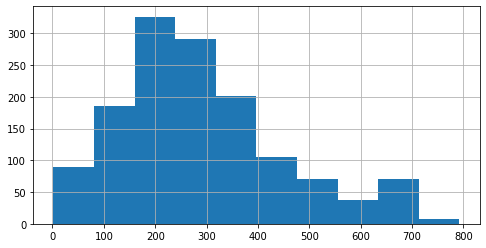

In [18]:
df.loc[df.lang_score == '', 'lang_score'] = np.nan
df.lang_score = df.lang_score.astype('float64')
df.lang_score.hist(figsize=(8,4));

In [19]:
df[df.lang_score < 50].sample(3)[['description'] + lang_api_columns]

,description,lang,lang_long,lang_score,lang_percent,lang_confidence
1381,ACG Club for Chinese students in UTSC,en,English,19.916814,100.0,True
445,Graduate Students' Association of Italian Studies (GSAIS),en,English,26.687031,100.0,False
1189,U of T Language Exchange Initiative,nl,Dutch,18.447229,100.0,False


In [20]:
mask = df.description.str.contains('description has not been provided', na=False)
print(f'{sum(mask)} groups with N/A descriptions:\n', df[mask].description.unique())
df.loc[mask, 'description'] = np.nan # Remove desciptions not sumitted by the organization
df.loc[df.description.isna(), lang_api_columns] = np.nan # clear language info for records with no descripton

12 groups with N/A descriptions:
 ['A description has not been provided to the Office of Student Life.'
 'A description has not been provided to the Office of Student Affairs.']


In [21]:
# df.lang.value_counts()
df[(df.lang != 'en') & ~df.lang.isna()][['description', 'lang', 'lang_long']]

,description,lang,lang_long
249,Political,sl,Slovenian
349,ERINDALE PUNJABI ASSOCIATION,it,Italian
559,VISION:,sv,Swedish
1025,L'Association des étudiants du département français assure la liaison entre les étudiants et les professeurs de français à UTSC . Les membres de c...,fr,French
1189,U of T Language Exchange Initiative,nl,Dutch
1338,Testing testing,nl,Dutch
1349,"Hội Sinh Viên Việt Nam Đại Học Toronto (UTVSA) là một tổ chức phi lợi nhuận được thành lập vào năm 1981. Từ khi bắt đầu, hội đã đề ra mục tiêu gìn...",vi,Vietnamese


With the exception of one organization description in French and another in Vietnamese, all other descriptions seem to be in English. Not fixing false match languages as they are not long enough for significant analysis.

In [43]:
t = nltk.tokenize.RegexpTokenizer(r'\w+')
stop_words = set(nltk.corpus.stopwords.words('english'))

def top_n_words(text, tokenizer, stop_words, n=5):
    word_tokens = tokenizer.tokenize(text.lower())
    filtered_tokens = [w for w in word_tokens if not w in stop_words]
    return list({k: v for k, v in sorted(Counter(filtered_tokens).items(),
                                         key=lambda val: val[1], reverse=True)}.items())[:n]


[('human', 3), ('health', 3), ('related', 2)]

In [51]:
mask = ~df.description.isna()
df.loc[mask, 'description_top_words'] = df[mask].description.apply(lambda x: top_n_words(x, t, stop_words))
df.sample(5)[['description_top_words']]

,description_top_words
1049,"[(goal, 1), (1, 1), (build, 1), (organize, 1), (community, 1)]"
484,"[(hart, 5), (house, 5), (singers, 3), (chorus, 3), (art, 2)]"
944,"[(students, 4), (opinions, 3), (meaningful, 2), (aim, 2), (create, 2)]"
24,"[(purpose, 1), (amsa, 1), (spread, 1), (awareness, 1), (true, 1)]"
894,"[(shaolin, 2), (ancient, 1), (times, 1), (combative, 1), (aspects, 1)]"


In [66]:
# 10 most frequent words in entire corpus
mask = ~df.description.isna()
top_n_words(df[mask].description.sum(), t, stop_words, 10)

[('students', 1513),
 ('university', 793),
 ('toronto', 682),
 ('student', 550),
 ('club', 513),
 ('community', 512),
 ('events', 468),
 ('members', 400),
 ('group', 373),
 ('provide', 356)]

In [73]:
mask = ~df.description.isna()
df.loc[mask, 'description_word_count'] = df[mask].description.apply(lambda x: len(x.split(' ')))
df.sample(5)[['description', 'description_word_count']]

,description,description_word_count
879,The Scarborough Model United Nations Conference at UTSC is an organization that is run by a highly motivated staff of undergraduate students that ...,136.0
529,NaN,NaN
1334,The purpose of this campaign is to work together every year to make a difference in the lives of those battling cystic fibrosis in Canada. Various...,95.0
1204,In order to motivate international students in University of Toronto to make friends and to be more connected with the local environment; To enric...,58.0
83,A Plan International Champion of Change Club at the University of Toronto Mississauga dedicated to promoting girls' rights and gender equality.,21.0


In [74]:
df.columns

Index(['campus_association', 'org_name', 'organization_type',
       'areas_of_interest', 'description', 'renewal_date',
       'group_email_address', 'mailing_address', 'primary_contact',
       'secondary_contact', 'telephone', 'social', 'website',
       'number_of_leaders', 'group_leader_01', 'group_leader_02',
       'group_leader_03', 'group_leader_04', 'group_leader_05',
       'group_leader_06', 'group_leader_07', 'group_leader_08',
       'group_leader_09', 'group_leader_10', 'group_leader_11',
       'group_leader_12', 'group_leader_13', 'group_leader_14',
       'group_leader_15', 'group_leader_16', 'group_leader_17',
       'group_leader_18', 'group_leader_19', 'group_leader_20',
       'group_leader_21', 'group_leader_22', 'group_leader_23',
       'group_leader_24', 'group_leader_25', 'group_leader_26',
       'group_leader_27', 'group_leader_28', 'page_uri', 'lang', 'lang_long',
       'lang_score', 'lang_percent', 'lang_confidence',
       'description_top_words', 'desc

In [75]:
df.drop(columns=['group_leader_01', 'group_leader_02', 'group_leader_03', 'group_leader_04', 'group_leader_05',
       'group_leader_06', 'group_leader_07', 'group_leader_08', 'group_leader_09', 'group_leader_10', 
       'group_leader_11', 'group_leader_12', 'group_leader_13', 'group_leader_14', 'group_leader_15', 
       'group_leader_16', 'group_leader_17', 'group_leader_18', 'group_leader_19', 'group_leader_20',
       'group_leader_21', 'group_leader_22', 'group_leader_23', 'group_leader_24', 'group_leader_25', 
       'group_leader_26', 'group_leader_27', 'group_leader_28', 'lang_percent', 'lang_confidence',
       'renewal_date','group_email_address', 'mailing_address', 'primary_contact',
       'secondary_contact', 'telephone', 'social'], inplace=True)

In [80]:
col_order = ['campus_association', 'org_name', 'organization_type', 'areas_of_interest', 'description', 
             'description_word_count', 'description_top_words','number_of_leaders','lang', 'lang_long', 
             'lang_score','website', 'page_uri']
df = df.reindex(col_order, axis=1)

In [81]:
df.sample(3)

,campus_association,org_name,organization_type,areas_of_interest,description,description_word_count,description_top_words,number_of_leaders,lang,lang_long,lang_score,website,page_uri
7,St. George,Actuarial Science Club,Recognized Student Group,Academic,The University of Toronto Actuarial Science Club is a student run organization focused on providing a positive experience for those in the Actuari...,53.0,"[(actuarial, 3), (science, 3), (club, 2), (program, 2), (university, 1)]",1.0,en,English,248.631133,NaN,https://www.ulife.utoronto.ca/organizations/view/id/2607
161,St. George,Carbon Cutting Racers,Recognized Student Group,"['Environment and Sustainability', 'Hobby and Leisure', 'Work and Career Development']",The Carbon Cutting Racers team redefines the limits of fuel efficiency. The team's goal is to push the boundaries of gasoline vehicle efficiency. ...,88.0,"[(vehicle, 4), (team, 3), (fuel, 3), (efficiency, 2), (compete, 2)]",1.0,en,English,352.338168,http://www.carboncutting.skule.ca,https://www.ulife.utoronto.ca/organizations/view/id/2035
344,Scarborough (UTSC),Environmental Sustainability Society (ESS),Recognized Student Group,"['Environment and Sustainability', 'Global Interests', 'Social Justice/Advocacy']",We are a group filled with passionate students who care about the environment! We aim to make a positive impact on our university community by rai...,62.0,"[(environment, 2), (community, 2), (daily, 2), (group, 1), (filled, 1)]",1.0,en,English,246.424921,NaN,https://www.ulife.utoronto.ca/organizations/view/id/128557


In [85]:
from excel_helper import xlsx_exporter

xlsx_exporter({'student_orgs': df}, 'datasets/edu/uoft_sudent_organizations_cleaned.xlsx')

Loading student_orgs

Saving Excel file...


In [86]:
df.to_csv('datasets/edu/uoft_sudent_organizations_cleaned.tsv', sep='\t', index=False)